<a href="https://colab.research.google.com/github/yunama47/CapstoneTeamC2-PC621/blob/main/Model/image_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import zipfile
import os
import shutil
tf.__version__

'2.12.0'

Download zip file from drive

In [2]:
url = 'https://drive.google.com/uc?id=1g6EQGwMZvstP7Q5uioca4Yk30n6DlfgU&export=download&confirm=t&uuid=8e8a3977-23b1-42ea-8178-5cfc6f8ef323'
local_zip = "/content/house_image.zip"
tf.keras.utils.get_file(fname=local_zip, origin=url)

314898372/314898372 [==============================] - 6s 0us/step


'/content/house_image.zip'

extract images

In [3]:
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [4]:
base_dir = '/content/Houses-Images'
uneligible_house_dir = os.path.join(base_dir,'not_eligible')
eligible_house_dir = os.path.join(base_dir,'eligible')

print(f'there is {len(os.listdir(uneligible_house_dir))} files in {uneligible_house_dir}')
print(f'there is {len(os.listdir(eligible_house_dir))} files in {eligible_house_dir}')

there is 90 files in /content/Houses-Images/not_eligible
there is 90 files in /content/Houses-Images/eligible


In [5]:
# create directory for train and test
def create_dir(dir):
  dir = os.path.join(base_dir,dir)
  os.mkdir(dir) if not os.path.isdir(dir) else print(f'{dir} already created')
  return dir

train_dir = create_dir('train')
test_dir = create_dir('test')
_ = create_dir('train/eligible')
_ = create_dir('train/not_eligible')
_ = create_dir('test/eligible')
_ = create_dir('test/not_eligible')

train test splitting

In [6]:
SPLIT_SIZE = 0.8
BATCH_SIZE = 18

In [7]:
import random

def train_test_split(imdir,split_size):

  def copy_files(files,copy_dir):
    label = imdir.split('/')[-1]
    for file in files:
      src = os.path.join(imdir,file)
      dst = os.path.join(copy_dir,label,file)
      shutil.copyfile(src,dst)

  img_files = os.listdir(imdir)
  random.shuffle(img_files)
  split = int(split_size * len(img_files))
  train_files = img_files[:split]
  test_files = img_files[split:]
  copy_files(train_files,train_dir)
  copy_files(test_files,test_dir)

train_test_split(eligible_house_dir,SPLIT_SIZE)
train_test_split(uneligible_house_dir,SPLIT_SIZE)

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150), 
        batch_size=BATCH_SIZE,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 144 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [13]:
import matplotlib.pyplot as plt

def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  print(f'last accucary result : acc = {acc[-1]}, val_acc = {val_acc[-1]}')
  print(f'last loss result : loss = {loss[-1]}, val_loss = {val_loss[-1]}')

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')

  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

create model

In [15]:
#create simple cnn network
def create_model(lr):
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16,3,input_shape=(150,150,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(lr),
                   loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                   metrics=['accuracy'])
  return model

last accucary result : acc = 0.7708333134651184, val_acc = 0.75
last loss result : loss = 0.4590262770652771, val_loss = 0.5090218186378479


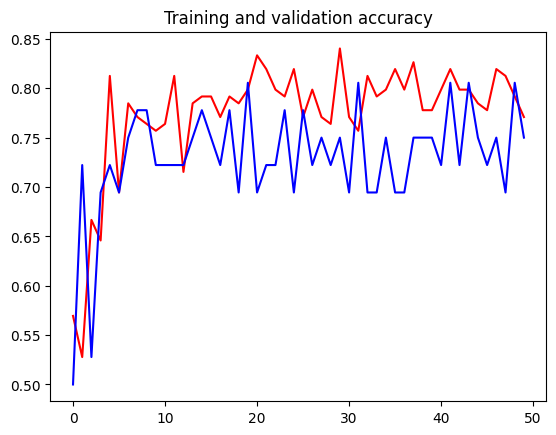

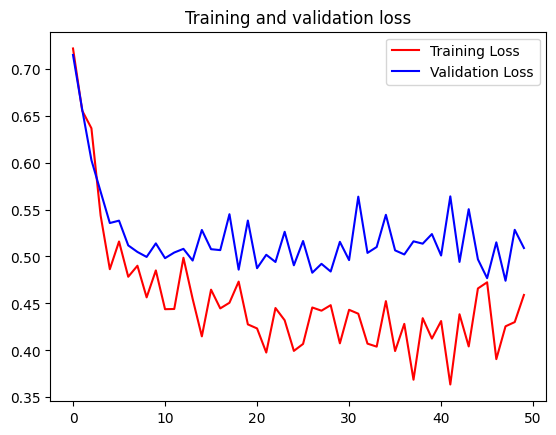

In [16]:
model = create_model(0.0001)
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator,
                    verbose=0)
plot_loss_acc(history)